In [1]:
!uv pip install -q scikit-learn==1.6.1 imbalanced-learn --system

In [2]:
!pip install -q -U scikit-learn imbalanced-learn

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (precision_recall_fscore_support,
                             roc_auc_score, average_precision_score,
                             RocCurveDisplay, PrecisionRecallDisplay,accuracy_score, log_loss)
from scipy.stats import chi2_contingency
sns.set_theme(style="whitegrid", palette="tab10", rc={'figure.figsize':(10,6)})
import torch, tensorflow as tf

2025-08-01 17:09:57.038945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754068197.390032      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754068197.492427      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print("Torch:", torch.cuda.is_available())
print("TF GPUs:", len(tf.config.list_physical_devices('GPU')))

Torch: True
TF GPUs: 2


In [ ]:
!gdown '13t-mmHaCNOin0b2_6_o_TG2CS3nKxiPT' -O alf_synthetic.csv

In [5]:
# df = pd.read_csv("/content/alf_synthetic.csv", parse_dates=["date"]) # for colab notebook
df = pd.read_csv("/kaggle/input/alf-synthetic/alf_synthetic.csv", parse_dates=["date"])  # for kaggle notebook
print("Shape:", df.shape)
display(df.head())

Shape: (60500, 12)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,patient_id,facility_id,date,age,gender,diagnosis,heart_rate,blood_pressure_sys,blood_pressure_dia,temperature,med_adherence,incident_next_day
0,P0001,F4,2024-01-01,93,Male,Osteoarthritis,79.0,130.0,90.0,36.9,0.95,0
1,P0001,F4,2024-01-02,93,Male,Osteoarthritis,NaN,170.0,88.0,36.2,0.82,0
2,P0001,F4,2024-01-03,93,Male,Osteoarthritis,77.0,131.0,90.0,36.4,0.91,0
3,P0001,F4,2024-01-04,93,Male,Osteoarthritis,68.0,138.0,94.0,36.5,0.81,0
4,P0001,F4,2024-01-05,93,Male,Osteoarthritis,65.0,114.0,78.0,36.5,0.95,0


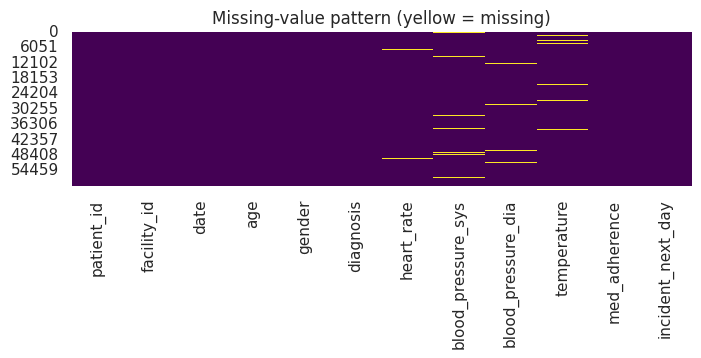

In [6]:
plt.figure(figsize=(8,2))
sns.heatmap(df.isna(), cbar=False, cmap="viridis")
plt.title("Missing-value pattern (yellow = missing)")
plt.show()

In [7]:
inc_rate = df["incident_next_day"].mean()
print(f"Overall incident rate: {inc_rate*100:.2f} %")

Overall incident rate: 6.23 %


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

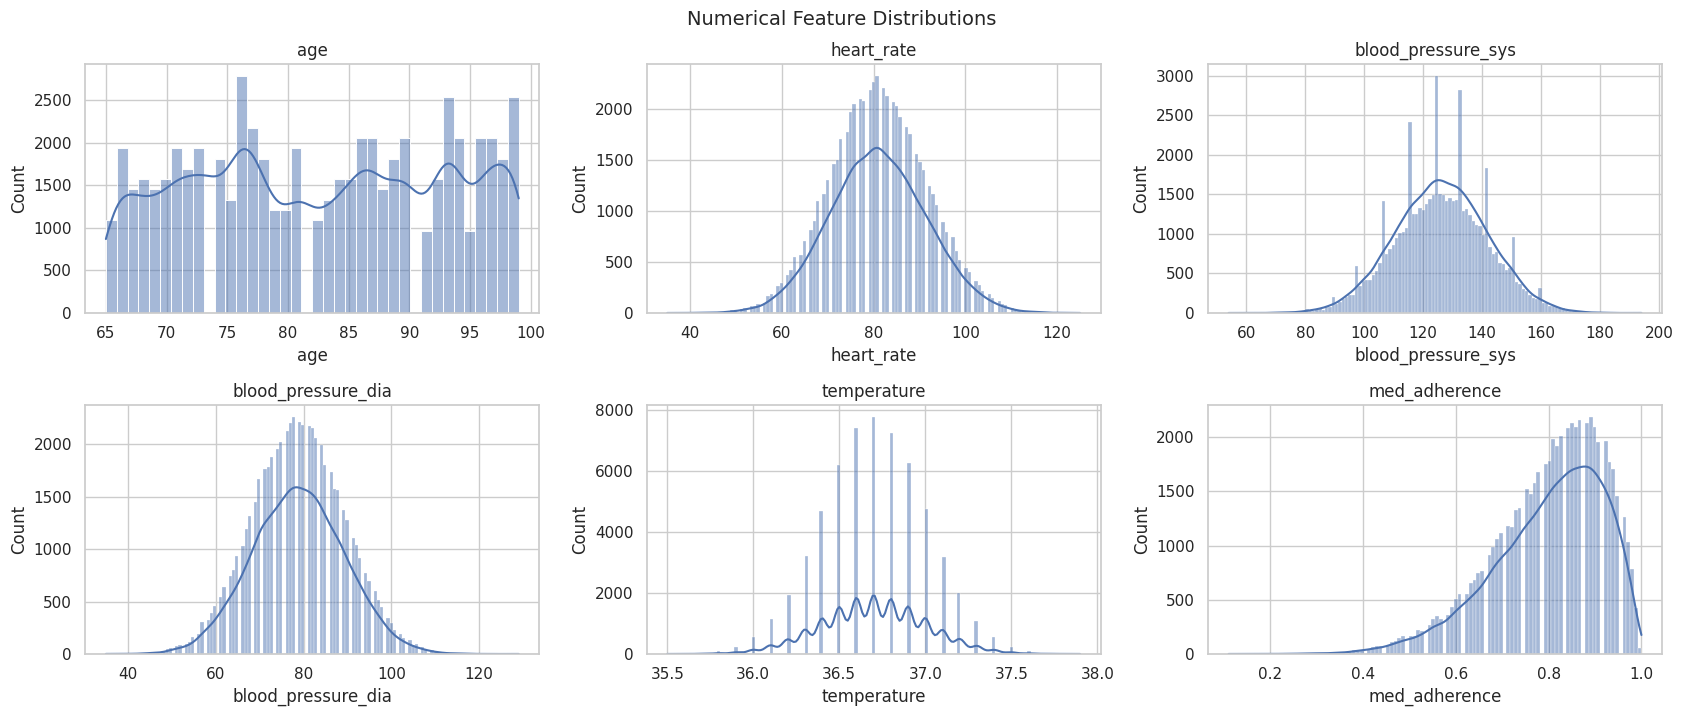

In [8]:
num_cols = ["age","heart_rate","blood_pressure_sys",
            "blood_pressure_dia","temperature","med_adherence"]

fig, axes = plt.subplots(2,3, figsize=(17,7))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    sns.histplot(df[col], kde=True, ax=ax, color="#4c72b0")
    ax.set_title(col)
plt.tight_layout()
plt.suptitle("Numerical Feature Distributions", y=1.02, fontsize=14)
plt.show()

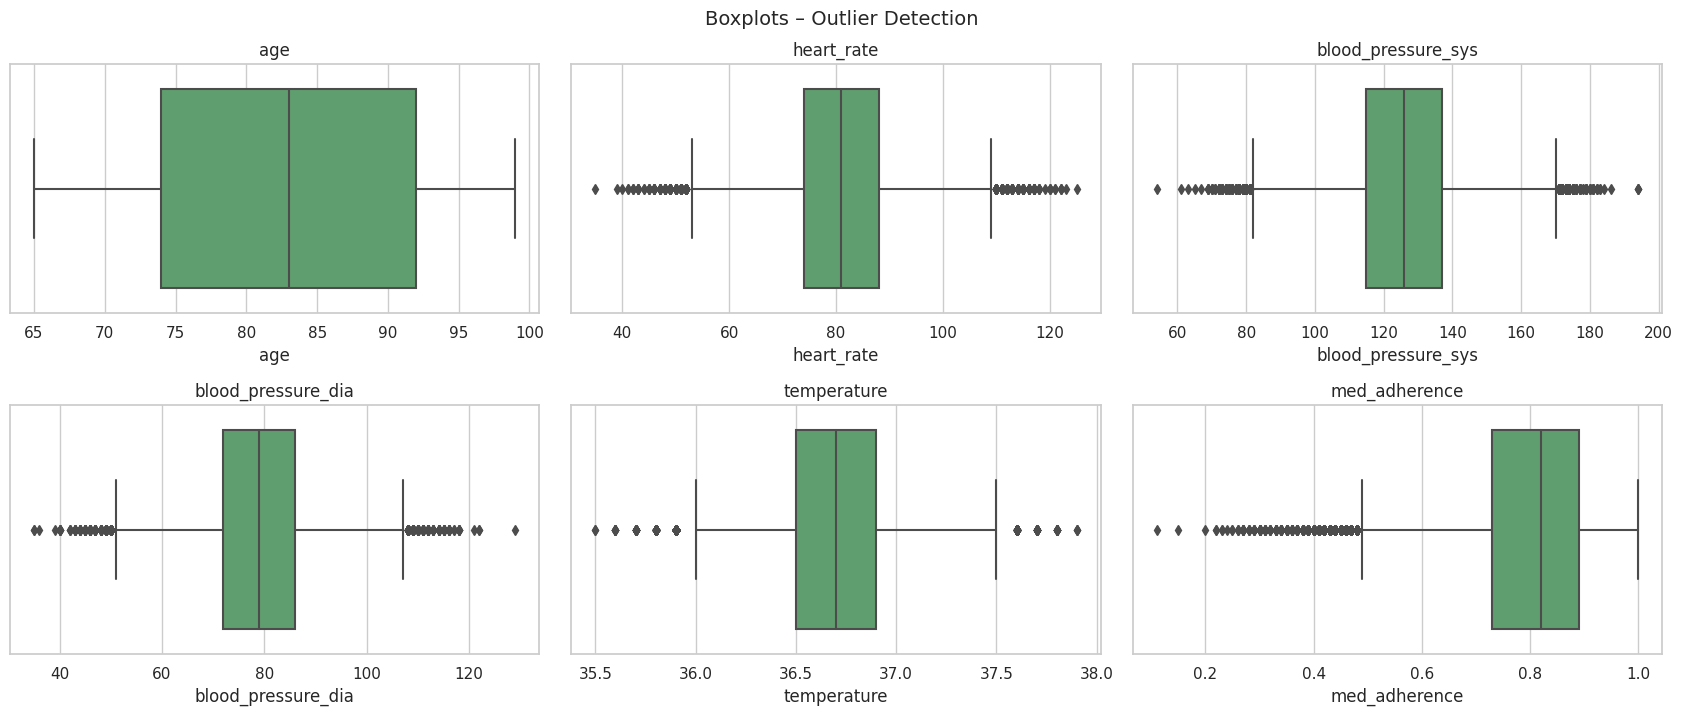

In [9]:
fig, axes = plt.subplots(2,3, figsize=(17,7))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    sns.boxplot(x=df[col], ax=ax, color="#55a868")
    ax.set_title(col)
plt.tight_layout()
plt.suptitle("Boxplots – Outlier Detection", y=1.02, fontsize=14)
plt.show()

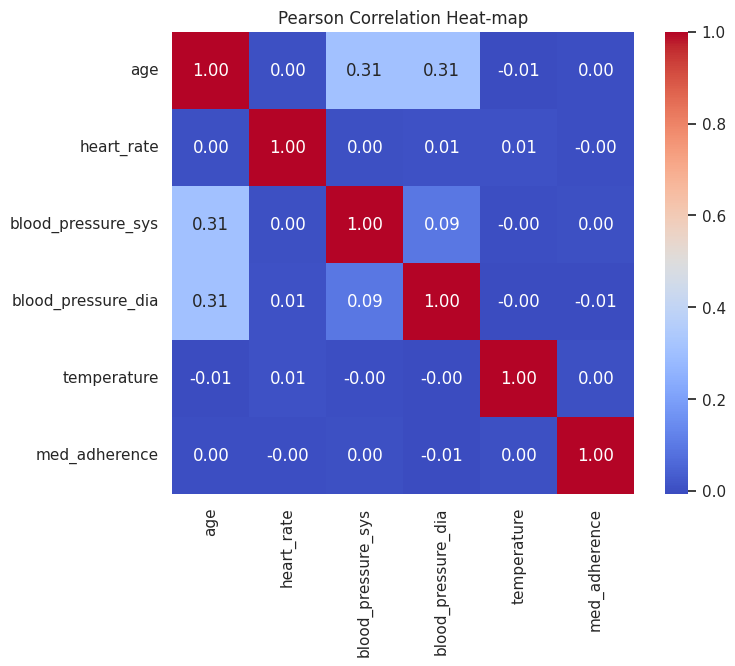

In [10]:
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pearson Correlation Heat-map")
plt.show()

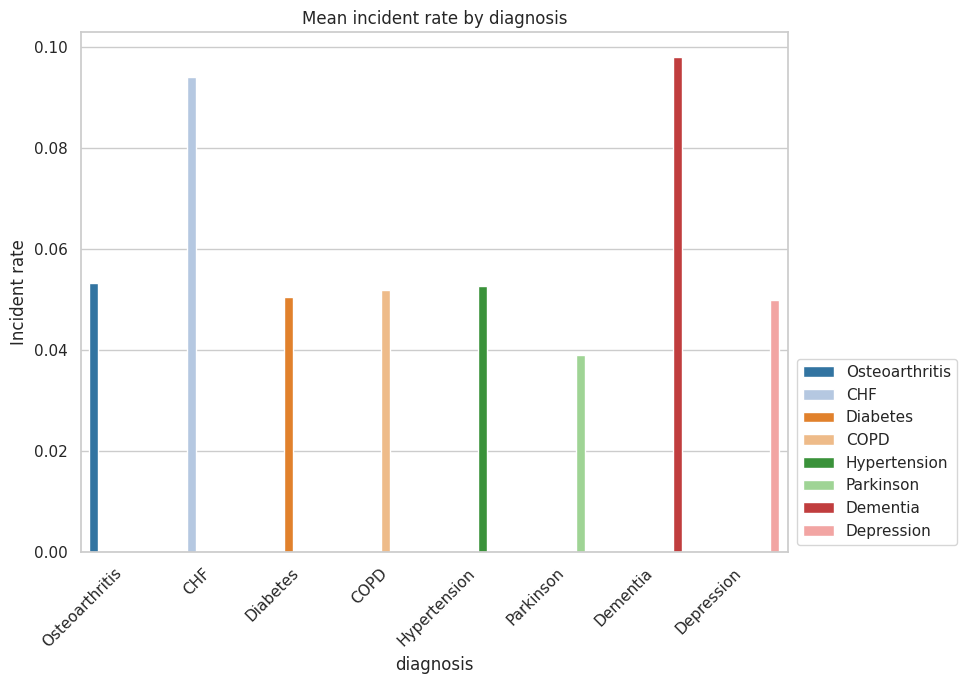

In [11]:
plt.figure(figsize=(10,7))
ax = sns.barplot(
    x="diagnosis",
    hue="diagnosis",
    y="incident_next_day",
    # legend=False,
    data=df,
    estimator=np.mean,
    # ci=None,
    errorbar=None,
    palette="tab20"
)

ax.set_title("Mean incident rate by diagnosis")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("Incident rate")
ax.legend(loc="lower right", bbox_to_anchor=(1.25, 0), frameon=True)

plt.tight_layout()
plt.show()

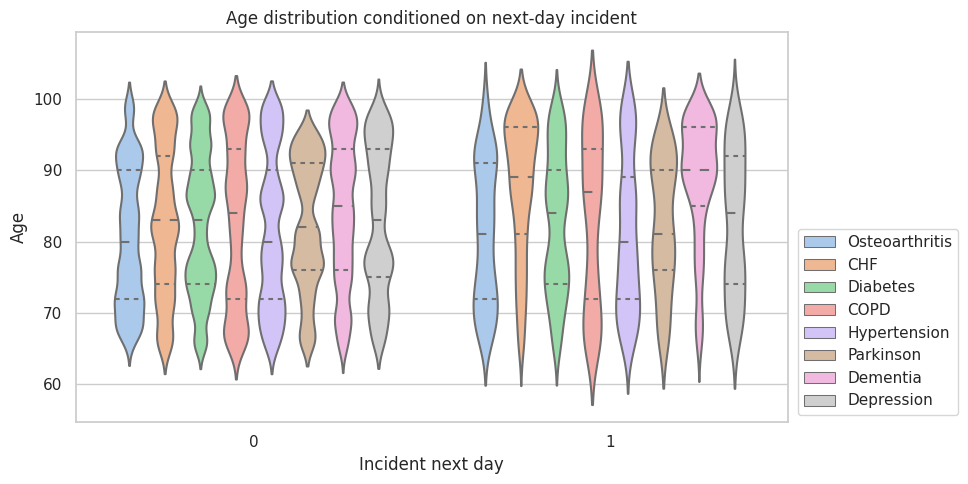

In [12]:
plt.figure(figsize=(10, 5))
ax = sns.violinplot(
    x="incident_next_day",
    hue="diagnosis",
    y="age",
    data=df,
    inner="quartile",
    palette="pastel"
)

ax.set_title("Age distribution conditioned on next-day incident")
ax.set_xlabel("Incident next day")
ax.set_ylabel("Age")
ax.legend(loc="lower right", bbox_to_anchor=(1.25, 0), frameon=True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


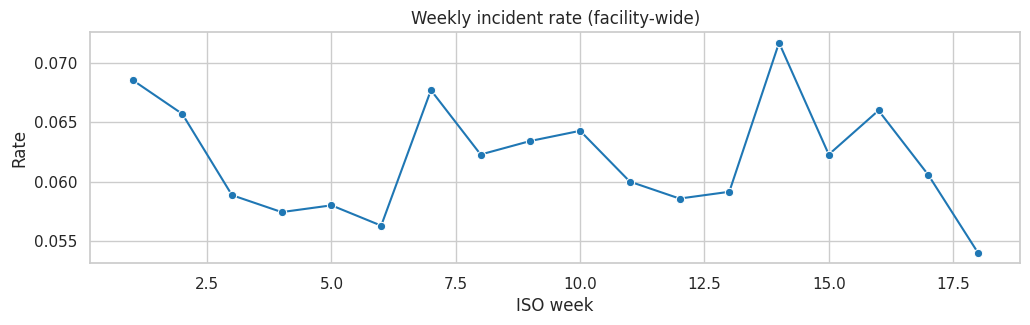

In [13]:
df["week"] = df["date"].dt.isocalendar().week
weekly_rate = df.groupby("week")["incident_next_day"].mean()

plt.figure(figsize=(12,3))
sns.lineplot(x=weekly_rate.index, y=weekly_rate.values, marker="o")
plt.title("Weekly incident rate (facility-wide)")
plt.xlabel("ISO week")
plt.ylabel("Rate")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


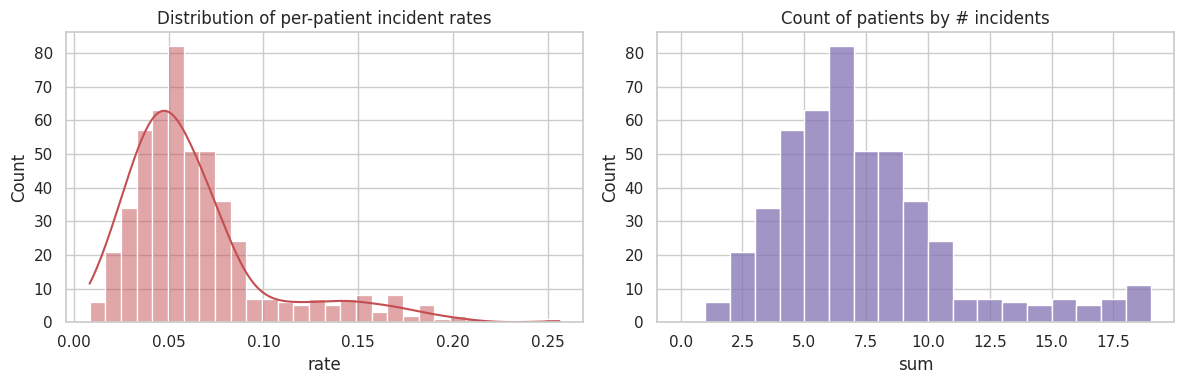

In [14]:
patient_stats = df.groupby("patient_id")["incident_next_day"].agg(["sum","count"])
patient_stats["rate"] = patient_stats["sum"] / patient_stats["count"]

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(patient_stats["rate"], bins=30, kde=True, ax=ax[0], color="#c44e52")
ax[0].set_title("Distribution of per-patient incident rates")

sns.histplot(patient_stats["sum"], bins=range(0, 20), kde=False, ax=ax[1], color="#8172b2")
ax[1].set_title("Count of patients by # incidents")
plt.tight_layout()
plt.show()

In [15]:
ct = pd.crosstab(df["diagnosis"], df["incident_next_day"])
chi2, p, _, _ = chi2_contingency(ct)
print(f"Chi² p-value (diagnosis vs incident): {p:.4f}")

Chi² p-value (diagnosis vs incident): 0.0000


# Fearture Engineering

In [34]:
df = df.sort_values(["patient_id", "date"])

In [35]:
# Utility: rolling stats per patient
def add_patient_lag(df, col, windows=[1,3,7]):
    """Add rolling mean & std for a vitals column."""
    for w in windows:
        df[f"{col}_mean_{w}d"] = (
            df.groupby("patient_id")[col]
              .transform(lambda s: s.rolling(window=w, min_periods=1).mean())
        )
        df[f"{col}_std_{w}d"] = (
            df.groupby("patient_id")[col]
              .transform(lambda s: s.rolling(window=w, min_periods=1).std())
        )
    return df

In [36]:
# vitals deltas & rolling stats
vitals = ["heart_rate", "blood_pressure_sys", "blood_pressure_dia", "temperature"]
for v in vitals:
    df = add_patient_lag(df, v)
    df[f"{v}_delta_1d"] = df.groupby("patient_id")[v].diff()

# risk proxies
df["age_group"] = pd.cut(df["age"], bins=[0,75,85,95,120],
                         labels=["<75","75-85","85-95",">95"])
df["med_adherence_bucket"] = pd.qcut(df["med_adherence"], q=4, labels=False)

# interaction flags
df["high_risk_diag"] = df["diagnosis"].isin(["Dementia","CHF","Parkinson"]).astype(int)
df["elderly"] = (df["age"] > 85).astype(int)

In [37]:
# Missing-value handling (MICE)
num_cols = (vitals +
            [c for c in df.columns if ("mean_" in c or "std_" in c or "delta_" in c)])
cat_cols = ["gender", "diagnosis", "age_group", "med_adherence_bucket"]

X = df[num_cols + cat_cols]
y = df["incident_next_day"]

# Build preprocessing pipelines
numeric_pipe = Pipeline([
    ("impute", IterativeImputer(random_state=42, max_iter=10)),
    ("scale",  StandardScaler())
])

categorical_pipe = Pipeline([
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc",  StandardScaler())]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

In [38]:
X = df[num_cols + cat_cols]
y = df["incident_next_day"]
groups = df["patient_id"]

# 20 % for (VAL + TEST)
gss1 = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state=42)
train_idx, valtest_idx = next(gss1.split(X, y, groups))

# VAL 10 % and TEST 10 %
gss2 = GroupShuffleSplit(test_size=0.50, n_splits=1, random_state=42)
val_idx, test_idx = next(gss2.split(X.iloc[valtest_idx], y.iloc[valtest_idx],
                                    groups.iloc[valtest_idx]))

val_idx   = valtest_idx[val_idx]
test_idx  = valtest_idx[test_idx]

In [39]:
X_clipped = X.copy()
for col in [c for c in num_cols if "delta_" in c]:
    X_clipped[col] = np.clip(X[col], -3 * X[col].std(), 3 * X[col].std())

# Fit on TRAIN only
X_train_raw, y_train_raw = X_clipped.iloc[train_idx], y.iloc[train_idx]
X_val_raw,   y_val_raw   = X_clipped.iloc[val_idx],   y.iloc[val_idx]
X_test_raw,  y_test_raw  = X_clipped.iloc[test_idx],  y.iloc[test_idx]

X_train_prep = preprocessor.fit_transform(X_train_raw)
X_val_prep   = preprocessor.transform(X_val_raw)
X_test_prep  = preprocessor.transform(X_test_raw)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/co

In [40]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_bal, y_train_bal = smote.fit_resample(X_train_prep, y_train_raw)

print("Train (SMOTE) :", X_train_bal.shape, "Positives:", y_train_bal.sum())
print("Validation    :", X_val_prep.shape,   "Positives:", y_val_raw.sum())
print("Test          :", X_test_prep.shape,  "Positives:", y_test_raw.sum())

Train (SMOTE) : (90782, 46) Positives: 45391
Validation    : (6050, 46) Positives: 385
Test          : (6050, 46) Positives: 373


In [41]:
import joblib
joblib.dump(preprocessor, "preprocessor.joblib")

['preprocessor.joblib']

In [42]:
models = {
    "CatBoost": cb.CatBoostClassifier(
        iterations=400,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        verbose=0,
        random_seed=42,
        class_weights={0:1, 1:int(len(y_train_bal)/sum(y_train_bal))}  # simple re-balance
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=63,
        objective='binary',
        metric='auc',
        class_weight='balanced',
        random_state=42,
        verbosity=-1
    )
}

In [44]:
results = []

for name, clf in models.items():
    # Fit on TRAIN (already SMOTE-balanced)
    clf.fit(X_train_bal, y_train_bal)
    
    # --- Validation evaluation ---
    y_pred_val = clf.predict(X_val_prep)
    y_prob_val = clf.predict_proba(X_val_prep)[:, 1]
    
    precision_v, recall_v, f1_v, _ = precision_recall_fscore_support(
        y_val_raw, y_pred_val, average='binary', zero_division=0)
    roc_v  = roc_auc_score(y_val_raw, y_prob_val)
    pr_v   = average_precision_score(y_val_raw, y_prob_val)
    acc_v  = accuracy_score(y_val_raw, y_pred_val)
    loss_v = log_loss(y_val_raw, y_prob_val)
    
    # # --- Test evaluation ---
    # y_pred_test = clf.predict(X_test_prep)
    # y_prob_test = clf.predict_proba(X_test_prep)[:, 1]
    
    # precision_t, recall_t, f1_t, _ = precision_recall_fscore_support(
    #     y_test_raw, y_pred_test, average='binary', zero_division=0)
    # roc_t  = roc_auc_score(y_test_raw, y_prob_test)
    # pr_t   = average_precision_score(y_test_raw, y_prob_test)
    # acc_t  = accuracy_score(y_test_raw, y_pred_test)
    # loss_t = log_loss(y_test_raw, y_prob_test)
    
    results.append({
        "Model": name,
        "Val_Acc": acc_v, "Val_Precision": precision_v, "Val_Recall": recall_v,
        "Val_F1": f1_v, "Val_ROC": roc_v, "Val_PR": pr_v, "Val_Loss": loss_v,
        # "Test_Acc": acc_t, "Test_Precision": precision_t, "Test_Recall": recall_t,
        # "Test_F1": f1_t, "Test_ROC": roc_t, "Test_PR": pr_t, "Test_Loss": loss_t
    })

pd.DataFrame(results).set_index("Model").round(3)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Val_Acc,Val_Precision,Val_Recall,Val_F1,Val_ROC,Val_PR,Val_Loss
Model,,,,,,,
CatBoost,0.936,0.167,0.003,0.005,0.558,0.091,0.278
LightGBM,0.936,0.000,0.000,0.000,0.546,0.085,0.243


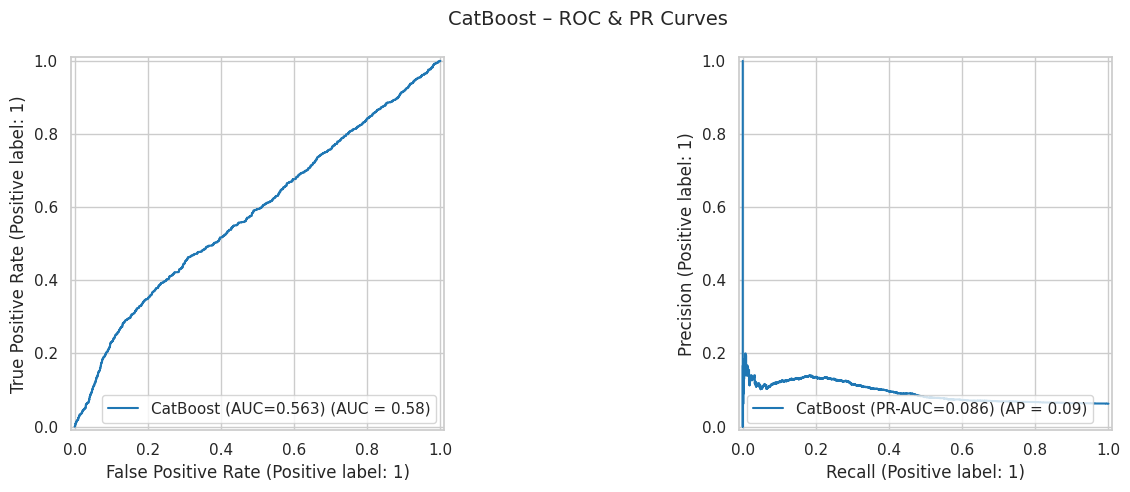

In [26]:
best_name = pd.DataFrame(results).set_index("Model")["PR-AUC"].idxmax()
best_clf  = models[best_name]
best_prob = best_clf.predict_proba(X_test_prep)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(14,5))
RocCurveDisplay.from_predictions(y_test_raw, best_prob, ax=ax[0],
                                 name=f"{best_name} (AUC={roc_auc:.3f})")
PrecisionRecallDisplay.from_predictions(y_test_raw, best_prob, ax=ax[1],
                                        name=f"{best_name} (PR-AUC={pr_auc:.3f})")
plt.suptitle(f"{best_name} – ROC & PR Curves", fontsize=14)
plt.tight_layout()
plt.show()

# Grid Search

In [45]:
X_tv_raw   = pd.concat([X_train_raw, X_val_raw])
y_tv       = pd.concat([y_train_raw, y_val_raw])
groups_tv  = pd.concat([groups[train_idx], groups[val_idx]])

In [51]:
# CatBoost Grid
cat_param_grid = {
    "clf__iterations":         [200, 400, 600],
    "clf__learning_rate":      [0.03, 0.05, 0.07],
    "clf__depth":              [4, 6, 8],
    "clf__l2_leaf_reg":        [1, 3, 5],
    "clf__border_count":       [32, 64]
}

cat_pipe = ImbPipeline(steps=[
    ("prep",  preprocessor),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("clf",   cb.CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        task_type='GPU',
        devices='0',
        thread_count=-1,
        random_seed=42,
        verbose=False))
])

# LightGBM Grid
lgb_param_grid = {
    "clf__n_estimators":       [200, 400, 600],
    "clf__learning_rate":      [0.03, 0.05, 0.07],
    "clf__max_depth":          [-1, 4, 6],
    "clf__num_leaves":         [31, 63, 127],
    "clf__min_child_samples":  [5, 15, 30],
    "clf__subsample":          [0.8, 1.0],
    "clf__colsample_bytree":   [0.8, 1.0]
}

lgb_pipe = ImbPipeline(steps=[
    ("prep",  preprocessor),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("clf",   lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        device='gpu',
        gpu_platform_id=0,
        gpu_device_id=0,
        random_state=42,
        missing=np.nan,
        verbosity=-1))
])

In [ ]:
def grid_tune(pipe, param_grid, model_name):
    pr_scorer = make_scorer(average_precision_score)
    X_tv = pd.concat([X_train_raw, X_val_raw])
    y_tv = pd.concat([y_train_raw, y_val_raw])

    gs = GridSearchCV(
        pipe,
        param_grid,
        cv=[(np.arange(len(X_train_raw)),
             np.arange(len(X_train_raw), len(X_tv)))],
        scoring=pr_scorer,
        n_jobs=1,
        verbose=2
    )
    gs.fit(X_tv, y_tv)

    print(f"{model_name} BEST PR-AUC: {gs.best_score_:.4f}")
    print(f"{model_name} BEST PARAMS: {gs.best_params_}")
    return gs.best_estimator_

best_cat = grid_tune(cat_pipe, cat_param_grid, "CatBoost")
best_lgb = grid_tune(lgb_pipe, lgb_param_grid, "LightGBM")

Fitting 1 folds for each of 162 candidates, totalling 162 fits


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   3.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   3.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   3.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   3.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   3.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   3.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   3.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=32, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=4, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=6, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   3.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   3.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   3.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=200, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   3.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=400, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.03; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.05; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=1, clf__learning_rate=0.07; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.03; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.05; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=3, clf__learning_rate=0.07; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.03; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.05; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__border_count=64, clf__depth=8, clf__iterations=600, clf__l2_leaf_reg=5, clf__learning_rate=0.07; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


CatBoost BEST PR-AUC: 0.0636
CatBoost BEST PARAMS: {'clf__border_count': 32, 'clf__depth': 4, 'clf__iterations': 200, 'clf__l2_leaf_reg': 1, 'clf__learning_rate': 0.03}
Fitting 1 folds for each of 972 candidates, totalling 972 fits


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning genera

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   7.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   9.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   9.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  15.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  15.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   6.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   9.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   9.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  15.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  14.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   6.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   8.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   8.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  14.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  14.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   5.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   8.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   8.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  15.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  15.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   5.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   8.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   8.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  14.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  14.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   8.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   8.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  14.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  14.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   8.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   8.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  15.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  14.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   5.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   8.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   8.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  14.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  14.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   5.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   5.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   9.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   9.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   8.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   8.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  14.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  14.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.3s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.07, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  11.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  11.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   9.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   9.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  15.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  16.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  11.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  11.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   6.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   9.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   9.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  15.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  15.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   6.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   9.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   9.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  15.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  15.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   5.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.03, clf__max_depth=6, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  11.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  11.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   9.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   9.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  15.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  16.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   6.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   6.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   9.1s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   9.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  15.5s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  15.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   6.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=  10.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=  10.4s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   8.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   8.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=  14.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=-1, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=  15.0s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=15, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=4, clf__min_child_samples=30, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=1.0; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=0.8; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=1.0; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=0.8; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=400, clf__num_leaves=127, clf__subsample=1.0; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=0.8; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=31, clf__subsample=1.0; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=0.8; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=63, clf__subsample=1.0; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=0.8; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=5, clf__n_estimators=600, clf__num_leaves=127, clf__subsample=1.0; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=0.8; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=63, clf__subsample=1.0; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['heart_rate_std_1d' 'blood_pressure_sys_std_1d'
 'blood_pressure_dia_std_1d' 'temperature_std_1d']. At least one non-missing value is needed for imputati

[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__max_depth=6, clf__min_child_samples=15, clf__n_estimators=200, clf__num_leaves=127, clf__subsample=0.8; total time=   2.8s


In [ ]:
# CatBoost best params
cat_best = best_cat.named_steps["clf"]
print("CatBoost best hyper-parameters:")
for k, v in cat_best.get_params().items():
    if k.startswith("iterations") or k.startswith("learning_rate") or \
       k.startswith("depth") or k.startswith("l2_leaf_reg"):
        print(f"  {k}: {v}")

# LightGBM best params
lgb_best = best_lgb.named_steps["clf"]
print("\nLightGBM best hyper-parameters:")
for k, v in lgb_best.get_params().items():
    if k in ["n_estimators", "learning_rate", "max_depth", "num_leaves",
             "min_child_samples"]:
        print(f"  {k}: {v}")

X_tv = pd.concat([X_train_raw, X_val_raw])
y_tv = pd.concat([y_train_raw, y_val_raw])
X_tv_prep = preprocessor.transform(X_tv)

y_prob_cat = best_cat.predict_proba(X_tv_prep)[:, 1]
y_prob_lgb = best_lgb.predict_proba(X_tv_prep)[:, 1]

pr_cat = average_precision_score(y_tv, y_prob_cat)
pr_lgb = average_precision_score(y_tv, y_prob_lgb)

print("\nValidation PR-AUC:")
print(f"  CatBoost : {pr_cat:.4f}")
print(f"  LightGBM : {pr_lgb:.4f}")

if pr_cat > pr_lgb:
    best_model, best_name = best_cat, "CatBoost"
    best_params = cat_best.get_params()
else:
    best_model, best_name = best_lgb, "LightGBM"
    best_params = lgb_best.get_params()

print(f"Best overall model: {best_name} (PR-AUC = {max(pr_cat, pr_lgb):.4f})")

In [ ]:
X_test_prep  = preprocessor.transform(X_test_raw)
y_pred_test  = best_model.predict(X_test_raw)
y_prob_test  = best_model.predict_proba(X_test_raw)[:, 1]

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_raw, y_pred_test, average='binary', zero_division=0)

roc  = roc_auc_score(y_test_raw, y_prob_test)
pr   = average_precision_score(y_test_raw, y_prob_test)
acc  = accuracy_score(y_test_raw, y_pred_test)
loss = log_loss(y_test_raw, y_prob_test)

print("=== FINAL TEST METRICS ===")
print(f"Accuracy : {acc:.4f}")
print(f"Log-loss : {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1       : {f1:.4f}")
print(f"ROC-AUC  : {roc:.4f}")
print(f"PR-AUC   : {pr:.4f}")